In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

In [2]:
df = pd.read_csv('../urbanbus_data/SER_0b91_start_aggregated.csv')

df_agg = df.groupby(["Ride_start_datetime", "Bus_Service_Number", "Direction", "Boarding_stop_stn", "Alighting_stop_stn"], as_index=False)["Passenger_Count"].sum()
df_agg['Ride_start_datetime'] = pd.to_datetime(df_agg['Ride_start_datetime'], errors='coerce')
df_agg = df_agg.sort_values('Ride_start_datetime').reset_index(drop=True)

print(f"Total records: {len(df_agg):,}")
print(f"Date range: {df_agg['Ride_start_datetime'].min()} to {df_agg['Ride_start_datetime'].max()}\n")

Total records: 600,672
Date range: 2017-10-01 00:00:00 to 2018-03-31 23:45:00



Top 5 Peak Hours by Total Passenger Flow
    hour  Passenger_Count
3      7            91171
14    18            86690
2      6            82542
13    17            69567
15    19            63844


/var/folders/ry/8lz3tm751074s32_zb2xmhpc0000gn/T/ipykernel_1743/2143956966.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


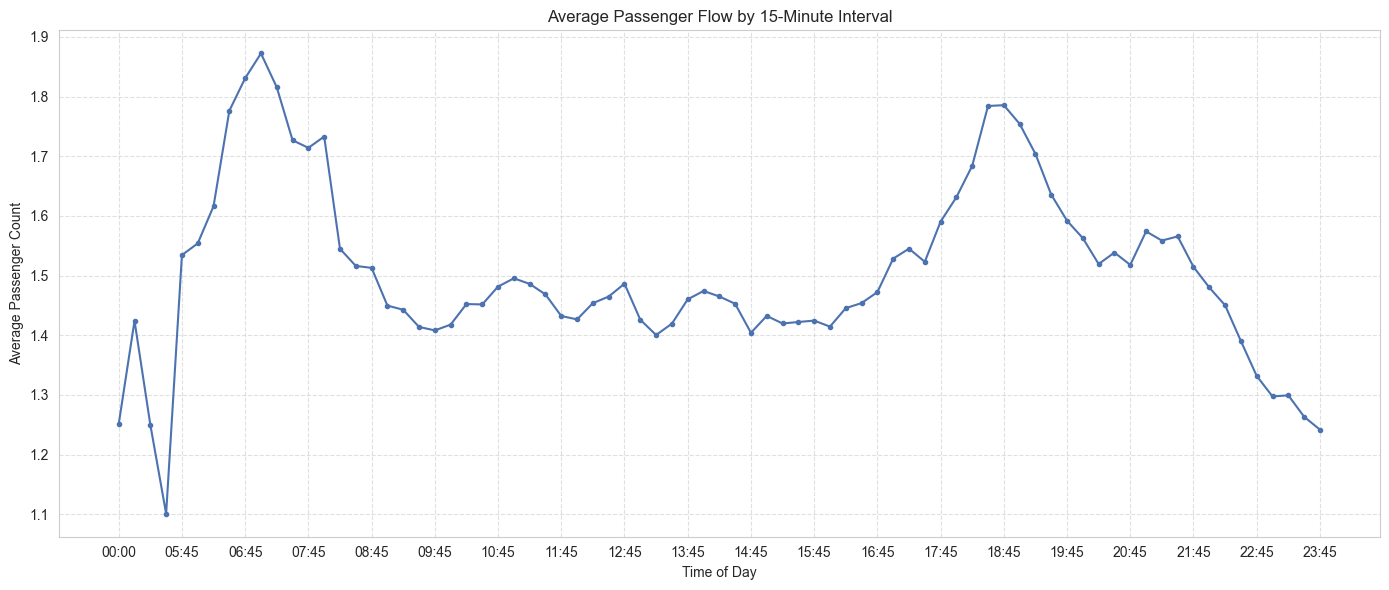

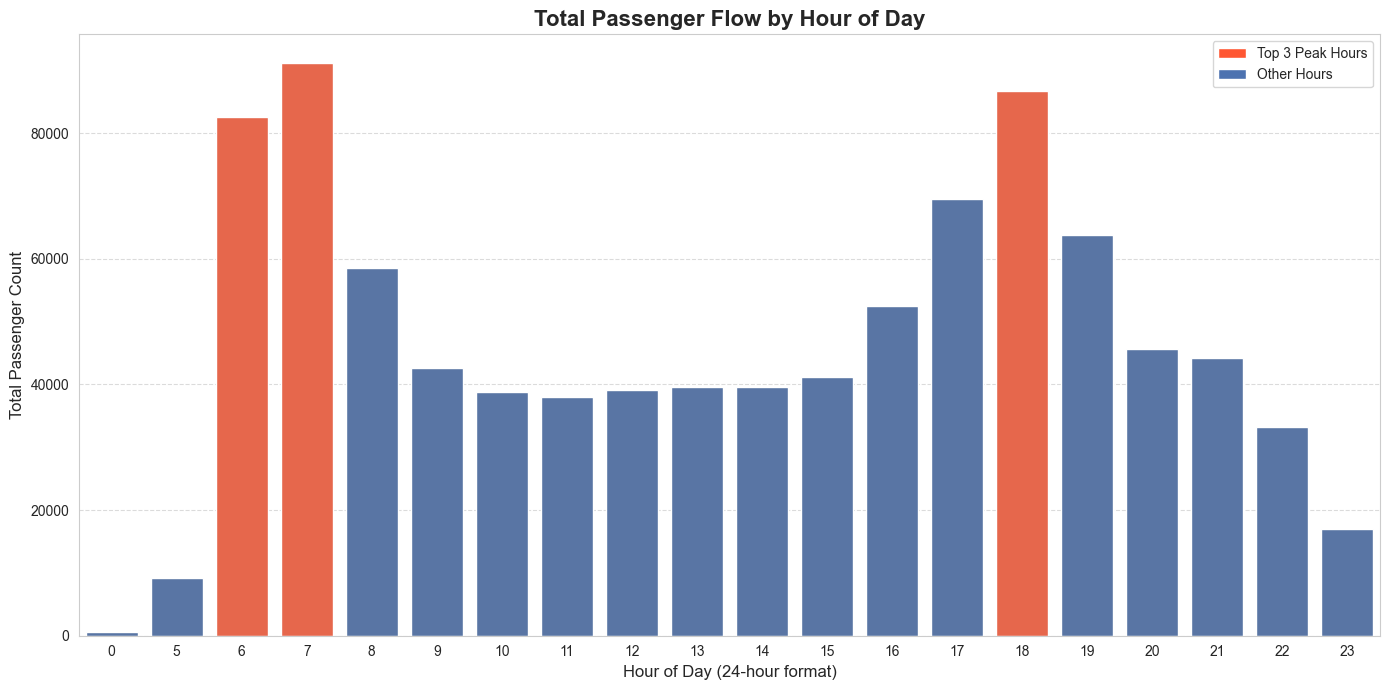

/var/folders/ry/8lz3tm751074s32_zb2xmhpc0000gn/T/ipykernel_1743/2143956966.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_avg_daily_flow.index, y=monthly_avg_daily_flow.values, palette='viridis')
/var/folders/ry/8lz3tm751074s32_zb2xmhpc0000gn/T/ipykernel_1743/2143956966.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dow_avg.index, y=dow_avg.values, palette=colors)


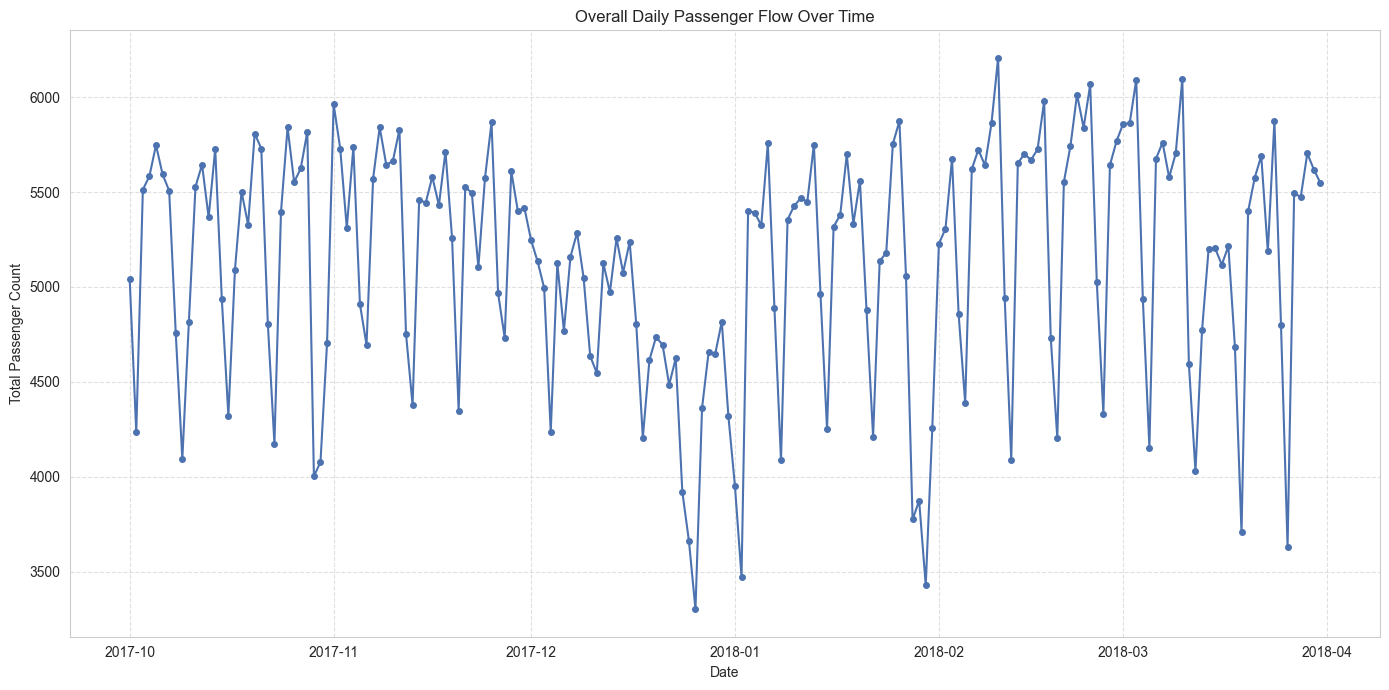

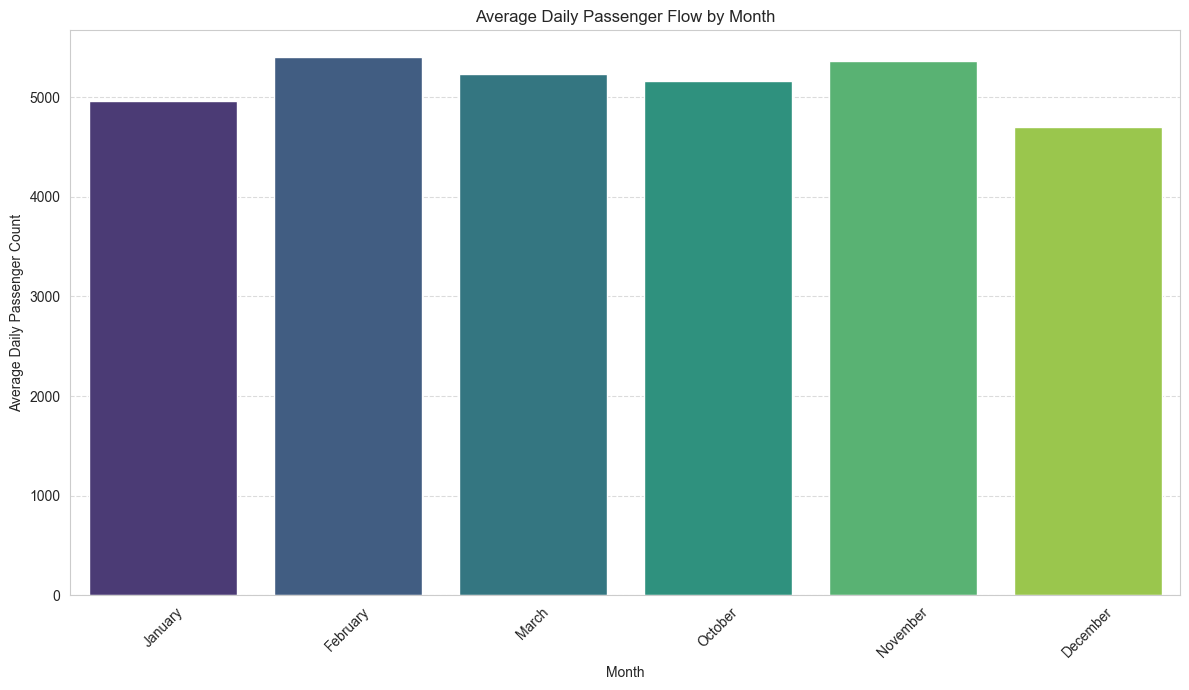

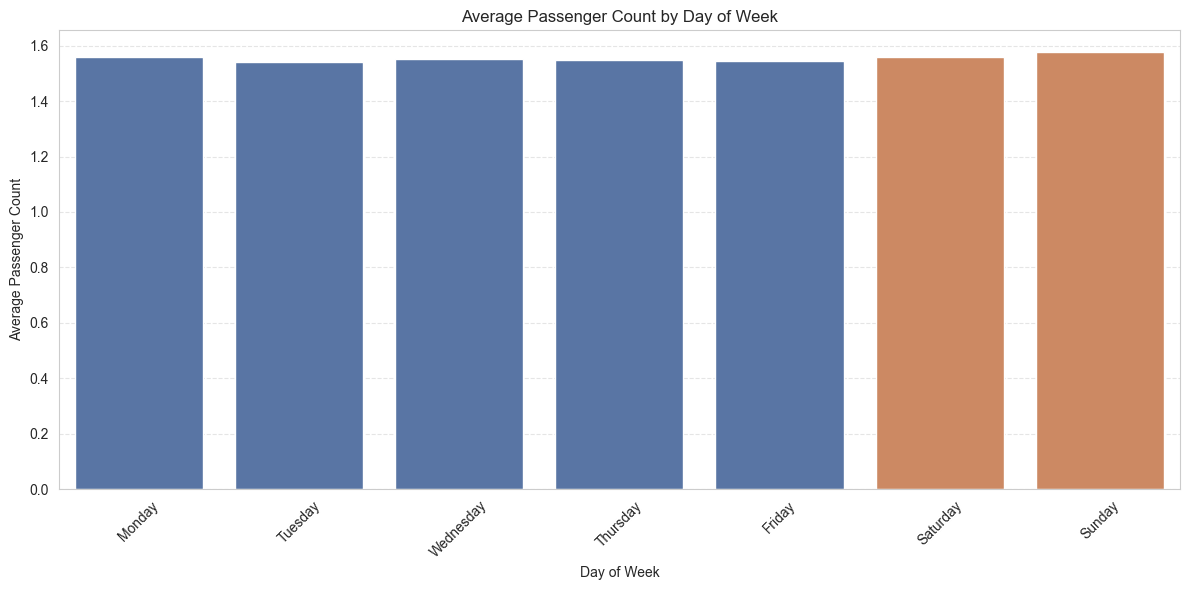

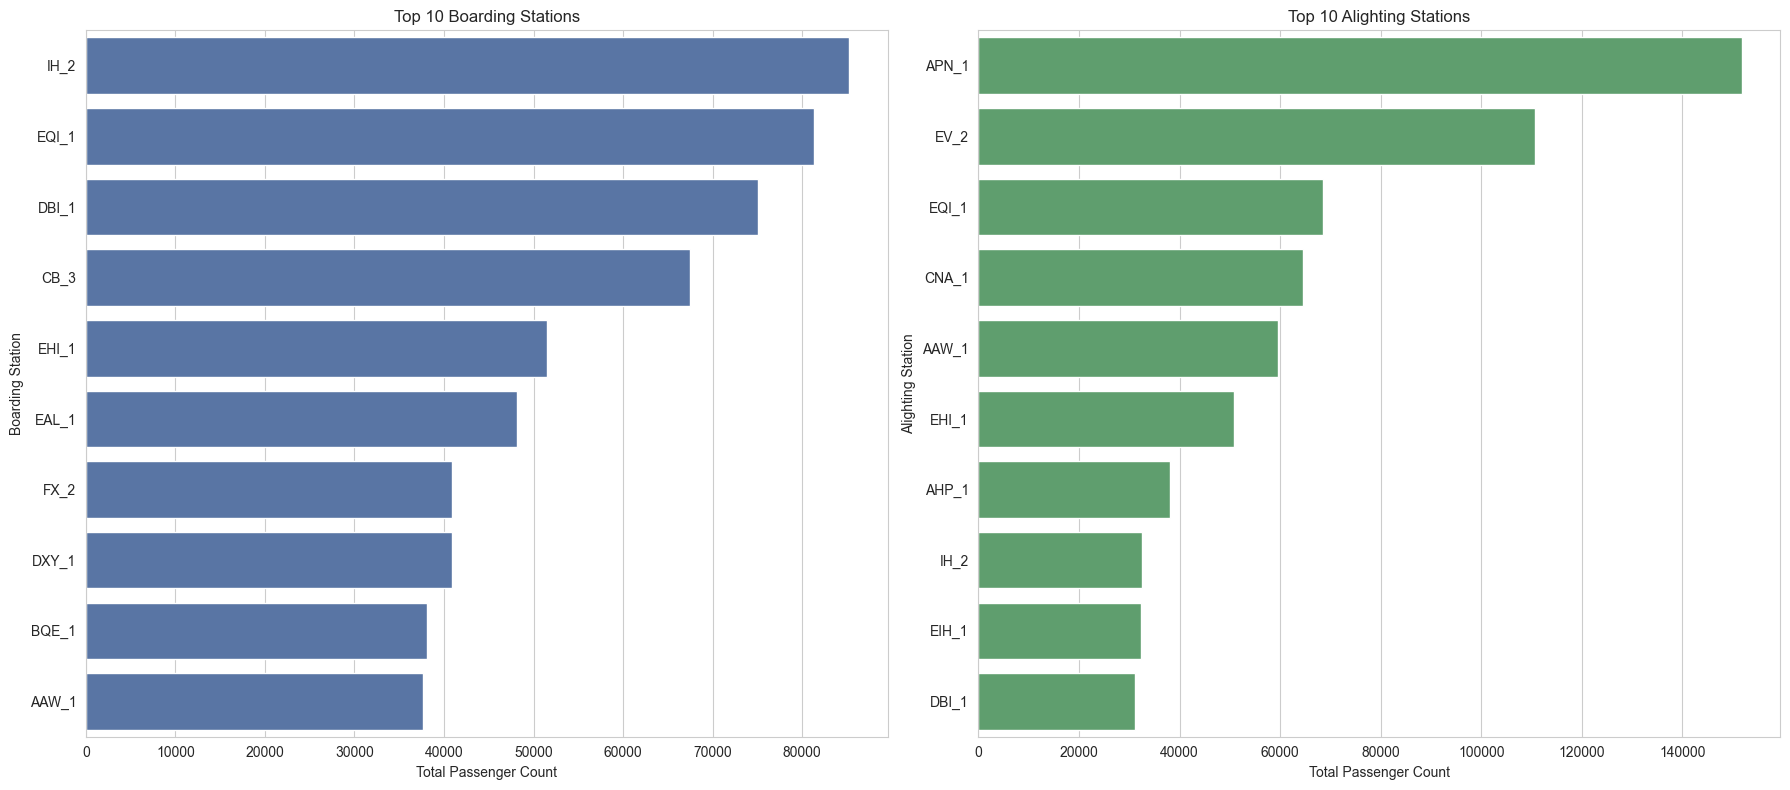

In [3]:
sns.set_style("whitegrid")
professional_palette = {
    "primary": "#4C72B0",
    "secondary": "#55A868",
    "weekday": "#4C72B0",
    "weekend": "#DD8452"
}

df_agg['day_name'] = df_agg['Ride_start_datetime'].dt.day_name()
df_agg['month_name'] = df_agg['Ride_start_datetime'].dt.month_name()
df_agg['time'] = df_agg['Ride_start_datetime'].dt.time

daily_flow = df_agg.groupby('time')['Passenger_Count'].mean().reset_index()
daily_flow['time_str'] = [t.strftime('%H:%M') for t in daily_flow['time']]

plt.figure(figsize=(14, 6))
plt.plot(daily_flow['time_str'], daily_flow['Passenger_Count'], marker='.', linestyle='-', color=professional_palette['primary'])
plt.title('Average Passenger Flow by 15-Minute Interval')
plt.xlabel('Time of Day')
plt.ylabel('Average Passenger Count')
plt.xticks(daily_flow['time_str'][::4])
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()


# ============================================================================
# 2. VISUALIZE THE HOURLY PASSENGER FLOW
# ============================================================================
if 'hour' not in df_agg.columns:
    df_agg['hour'] = df_agg['Ride_start_datetime'].dt.hour

hourly_flow = df_agg.groupby('hour')['Passenger_Count'].sum().reset_index()

# Sort to find the hours with the most passengers
peak_hours = hourly_flow.sort_values('Passenger_Count', ascending=False)

print("="*40)
print("Top 5 Peak Hours by Total Passenger Flow")
print("="*40)
print(peak_hours.head())
print("="*40)

plt.figure(figsize=(14, 7))

# Create a color palette that highlights the top 3 peak hours
top_3_hours = peak_hours['hour'].head(3).tolist()
colors = ['#FF5733' if h in top_3_hours else '#4C72B0' for h in hourly_flow['hour']]

# Create the bar plot
ax = sns.barplot(
    data=hourly_flow,
    x='hour',
    y='Passenger_Count',
    palette=colors
)

# Add titles and labels for clarity
plt.title('Total Passenger Flow by Hour of Day', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day (24-hour format)', fontsize=12)
plt.ylabel('Total Passenger Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend for the highlight color
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#FF5733', label='Top 3 Peak Hours'),
                   Patch(facecolor='#4C72B0', label='Other Hours')]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

# --- Plot 2: Overall Boarding Passenger Flow Over Time ---
overall_flow = df_agg.set_index('Ride_start_datetime')['Passenger_Count'].resample('D').sum()

plt.figure(figsize=(14, 7))
plt.plot(overall_flow.index, overall_flow.values, marker='o', linestyle='-', markersize=4, color=professional_palette['primary'])
plt.title('Overall Daily Passenger Flow Over Time')
plt.xlabel('Date')
plt.ylabel('Total Passenger Count')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# --- Plot 3: Average Daily Passenger Flow by Month ---
daily_totals = df_agg.groupby(df_agg['Ride_start_datetime'].dt.date)['Passenger_Count'].sum().reset_index()
daily_totals.rename(columns={'Ride_start_datetime': 'date'}, inplace=True)
daily_totals['date'] = pd.to_datetime(daily_totals['date'])
daily_totals['month_name'] = daily_totals['date'].dt.month_name()
monthly_avg_daily_flow = daily_totals.groupby('month_name')['Passenger_Count'].mean()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_avg_daily_flow = monthly_avg_daily_flow.reindex(month_order).dropna()

plt.figure(figsize=(12, 7))
sns.barplot(x=monthly_avg_daily_flow.index, y=monthly_avg_daily_flow.values, palette='viridis')
plt.title('Average Daily Passenger Flow by Month')
plt.xlabel('Month')
plt.ylabel('Average Daily Passenger Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# --- Plot 4: Average Passenger Count by Day of Week ---
dow_avg = df_agg.groupby('day_name')['Passenger_Count'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
colors = [professional_palette['weekday'] if day not in ['Saturday', 'Sunday'] else professional_palette['weekend'] for day in dow_avg.index]

plt.figure(figsize=(12, 6))
sns.barplot(x=dow_avg.index, y=dow_avg.values, palette=colors)
plt.title('Average Passenger Count by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Passenger Count')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.5, linestyle='--', axis='y')
plt.tight_layout()

# --- Plot 5: Top 10 Boarding and Alighting Stations ---
top_boarding = df_agg.groupby('Boarding_stop_stn')['Passenger_Count'].sum().nlargest(10)
top_alighting = df_agg.groupby('Alighting_stop_stn')['Passenger_Count'].sum().nlargest(10)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.barplot(ax=axes[0], y=top_boarding.index, x=top_boarding.values, color=professional_palette['primary'], orient='h')
axes[0].set_xlabel('Total Passenger Count')
axes[0].set_ylabel('Boarding Station')
axes[0].set_title('Top 10 Boarding Stations')

sns.barplot(ax=axes[1], y=top_alighting.index, x=top_alighting.values, color=professional_palette['secondary'], orient='h')
axes[1].set_xlabel('Total Passenger Count')
axes[1].set_ylabel('Alighting Station')
axes[1].set_title('Top 10 Alighting Stations')

plt.tight_layout()